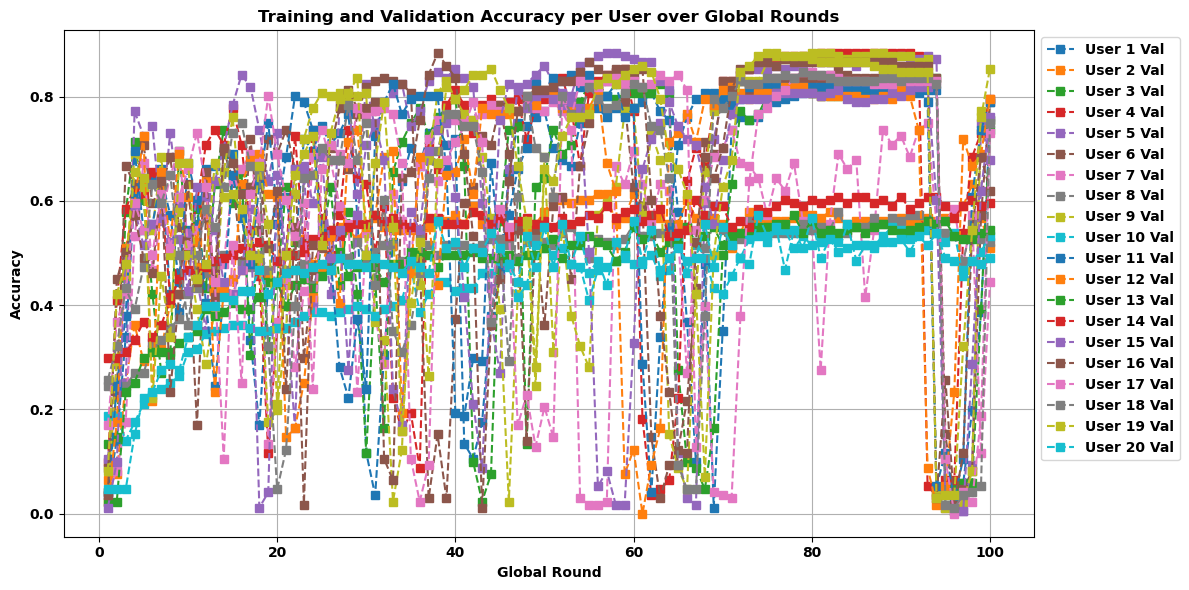

In [8]:
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Read the log file
file_path = "FMTLresults.txt"  # Change this to your actual file path
with open(file_path, "r") as f:
    logs = f.readlines()

# Initialize dictionaries to store extracted values
user_train_accuracies = defaultdict(list)
user_val_accuracies = defaultdict(list)
global_rounds = set()

# Regex patterns to match accuracy values
train_pattern = re.compile(r"Training model for User (\d+).*?Accuracy: ([0-9.]+)")
val_pattern = re.compile(r"User (\d+) - Validation Loss: [0-9.]+, Accuracy: ([0-9.]+)")
global_round_pattern = re.compile(r"Global Round (\d+)")

current_round = None

# Parse the log file
for line in logs:
    round_match = global_round_pattern.search(line)
    if round_match:
        current_round = int(round_match.group(1))
        global_rounds.add(current_round)
    
    train_match = train_pattern.search(line)
    if train_match and current_round is not None:
        user_id = int(train_match.group(1))
        accuracy = float(train_match.group(2))
        user_train_accuracies[user_id].append((current_round, accuracy))
    
    val_match = val_pattern.search(line)
    if val_match and current_round is not None:
        user_id = int(val_match.group(1))
        accuracy = float(val_match.group(2))
        user_val_accuracies[user_id].append((current_round, accuracy))


# Plot the results for each user
plt.figure(figsize=(12, 6))
for user_id, acc_list in user_train_accuracies.items():
    rounds, acc = zip(*sorted(acc_list))
    plt.plot(rounds, acc, marker="o", label=f"User {user_id} Train")
    
for user_id, acc_list in user_val_accuracies.items():
    rounds, acc = zip(*sorted(acc_list))
    plt.plot(rounds, acc, marker="s", linestyle="--", label=f"User {user_id} Val")

plt.xlabel("Global Round")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per User over Global Rounds")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
user_train_accuracies

defaultdict(list, {})

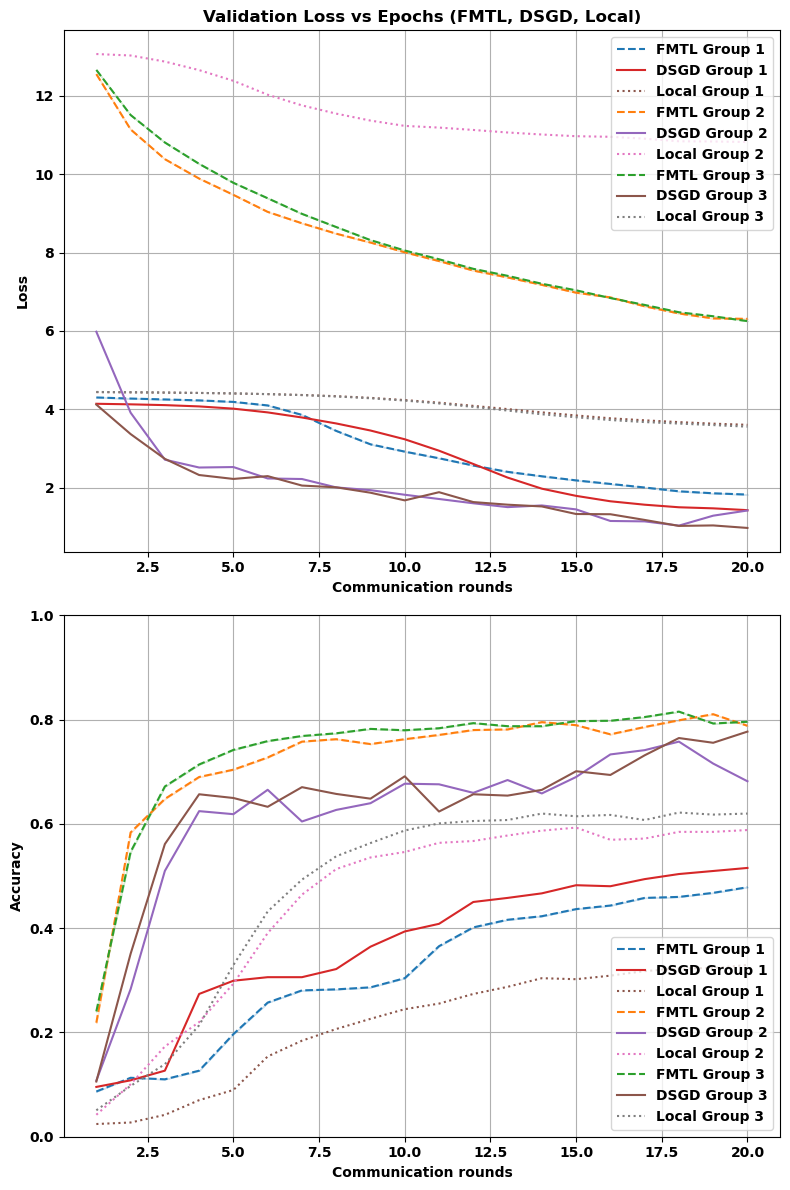

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Define metrics directory and file paths
metrics_directory = "./"
fmtl_metrics_file = f'{metrics_directory}FMTL_metrics_randn_P_adam.json'
dsgd_metrics_file = f'{metrics_directory}DSGD_results_adam.json'
local_metrics_file = f'{metrics_directory}local_drone.json'
# Load the metrics from JSON files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

fmtl_metrics = load_json(fmtl_metrics_file)
dsgd_metrics = load_json(dsgd_metrics_file)
local_metrics = load_json(local_metrics_file)


# Convert metrics to numpy arrays
fmtl_group_train_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_train_loss_mean'].items()}
fmtl_group_val_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_mean'].items()}
fmtl_group_val_accuracy_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_mean'].items()}

# Standard deviations
fmtl_group_train_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_train_loss_std'].items()}
fmtl_group_val_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_std'].items()}
fmtl_group_val_acc_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_std'].items()}

# Load DSGD and Local metrics
dsgd_group_val_loss_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_loss_mean'].items()}
dsgd_group_val_accuracy_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_mean'].items()}
local_group_val_loss_histories = {k: np.array(v) for k, v in local_metrics['group_val_loss_mean'].items()}
local_group_val_accuracy_histories = {k: np.array(v) for k, v in local_metrics['group_val_acc_mean'].items()}

# Plot results
plt.figure(figsize=(8, 12))

# Validation Loss Plot
plt.subplot(2, 1, 1)
for group in fmtl_group_val_loss_histories.keys():
    epochs = range(1, len(fmtl_group_val_loss_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_loss_histories[group], label=f"FMTL Group {group}", linestyle="dashed", color=f'C{int(group)-1}')
    plt.fill_between(epochs, 
                     fmtl_group_val_loss_histories[group] - fmtl_group_val_loss_std[group], 
                     fmtl_group_val_loss_histories[group] + fmtl_group_val_loss_std[group], 
                     alpha=0.2, color=f'C{int(group)-1}')
    
    plt.plot(epochs, dsgd_group_val_loss_histories[group], label=f"DSGD Group {group}", linestyle="solid", color=f'C{int(group)+2}')
    plt.plot(epochs, local_group_val_loss_histories[group][:20], label=f"Local Group {group}", linestyle="dotted", color=f'C{int(group)+4}')
    
plt.title("Validation Loss vs Epochs (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid()

# Validation Accuracy Plot
plt.subplot(2, 1, 2)
for group in fmtl_group_val_accuracy_histories.keys():
    epochs = range(1, len(fmtl_group_val_accuracy_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_accuracy_histories[group], label=f"FMTL Group {group}", linestyle="dashed", color=f'C{int(group)-1}')
    plt.fill_between(epochs, 
                     fmtl_group_val_accuracy_histories[group] - fmtl_group_val_acc_std[group], 
                     fmtl_group_val_accuracy_histories[group] + fmtl_group_val_acc_std[group], 
                     alpha=0.2, color=f'C{int(group)-1}')
    
    plt.plot(epochs, dsgd_group_val_accuracy_histories[group], label=f"DSGD Group {group}", linestyle="solid", color=f'C{int(group)+2}')
    plt.plot(epochs, local_group_val_accuracy_histories[group][:20], label=f"Local Group {group}", linestyle="dotted", color=f'C{int(group)+4}')
    
#plt.title("Validation Accuracy vs Communication Rounds (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Accuracy should be between 0 and 1
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()

In [93]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Full image convergence

<Figure size 800x1200 with 0 Axes>

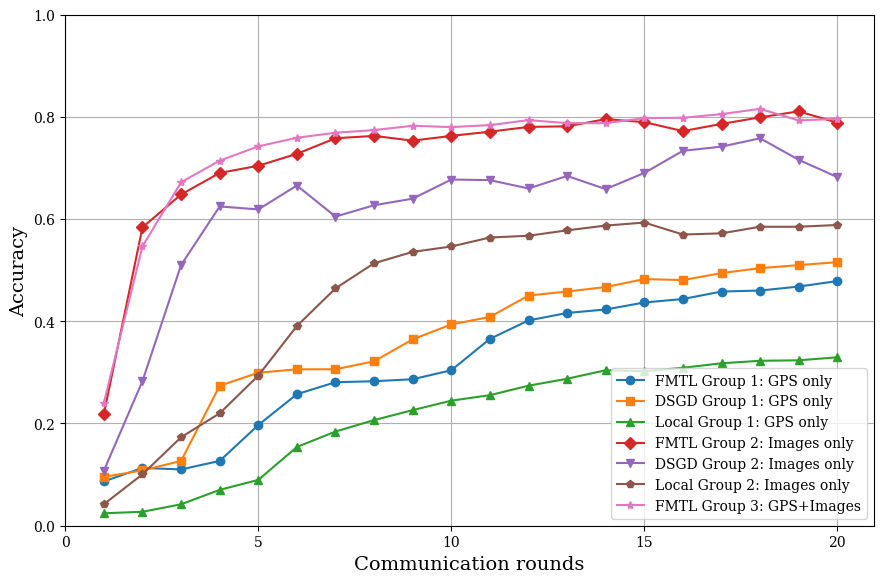

In [135]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Define metrics directory and file paths
metrics_directory = "./"
fmtl_metrics_file = f'{metrics_directory}FMTL_metrics_randn_P_adam.json'
dsgd_metrics_file = f'{metrics_directory}DSGD_results_adam.json'
local_metrics_file = f'{metrics_directory}local_drone.json'
centralized_metrics_file = f'{metrics_directory}centralized_drone.json'

# Load the metrics from JSON files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

fmtl_metrics = load_json(fmtl_metrics_file)
dsgd_metrics = load_json(dsgd_metrics_file)
local_metrics = load_json(local_metrics_file)
centralized_metrics = load_json(centralized_metrics_file)

# Convert metrics to numpy arrays
fmtl_group_val_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_mean'].items()}
fmtl_group_val_accuracy_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_mean'].items()}
# Load DSGD and Local metrics
dsgd_group_val_loss_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_loss_mean'].items() if k != '3'}
dsgd_group_val_accuracy_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_mean'].items() if k != '3'}
local_group_val_loss_histories = {k: np.array(v) for k, v in local_metrics['group_val_loss_mean'].items() if k != '3'}
local_group_val_accuracy_histories = {k: np.array(v) for k, v in local_metrics['group_val_acc_mean'].items() if k != '3'}
central_group_val_loss_histories = {k: np.array(v) for k, v in centralized_metrics['group_val_loss_mean'].items()}
central_group_val_accuracy_histories = {k: np.array(v) for k, v in centralized_metrics['group_val_acc_mean'].items()}


# Standard deviations
fmtl_group_val_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_std'].items()}
fmtl_group_val_acc_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_std'].items()}
dsgd_group_val_acc_std = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_std'].items()}
local_group_val_acc_std = {k: np.array(v) for k, v in local_metrics['group_val_acc_std'].items()}
central_group_val_acc_std = {k: np.array(v) for k, v in centralized_metrics['group_val_acc_std'].items()}
central_group_val_loss_std = {k: np.array(v) for k, v in centralized_metrics['group_val_loss_std'].items()}

# Rename groups
group_names = {'1': 'Group 1: GPS only', '2': 'Group 2: Images only', '3': 'Group 3: GPS+Images'}


markers = ['o', 's', '^', 'D', 'v', 'p', '*']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']  # Blue, Orange, Green, Red, Purple, Brown, Pink


# Plot results
plt.figure(figsize=(8, 12))
'''
# Validation Loss Plot
plt.subplot(2, 1, 1)
i = 0
for group in fmtl_group_val_loss_histories.keys():
    
    epochs = range(1, len(fmtl_group_val_loss_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_loss_histories[group], label=f"FMTL {group_names[group]}", marker=markers[i], color=colors[i])
    i = i + 1
    
    if group in dsgd_group_val_loss_histories:
        plt.plot(epochs, dsgd_group_val_loss_histories[group], label=f"DSGD {group_names[group]}", marker=markers[i], color=colors[i])  # Red
        i = i + 1
    if group in local_group_val_loss_histories:
        plt.plot(epochs, local_group_val_loss_histories[group], label=f"Local {group_names[group]}", marker=markers[i], color=colors[i])  # Purple
        i = i + 1
plt.title("Validation Loss vs Communication Rounds (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid()
'''
i = 0
# Validation Accuracy Plot
#plt.subplot(2, 1, 2)
plt.figure(figsize=(9, 6))

for group in fmtl_group_val_accuracy_histories.keys():
    epochs = range(1, len(fmtl_group_val_accuracy_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_accuracy_histories[group], label=f"FMTL {group_names[group]}", marker=markers[i], color=colors[i])
    i = i + 1
    if group in dsgd_group_val_accuracy_histories:
        plt.plot(epochs, dsgd_group_val_accuracy_histories[group], label=f"DSGD {group_names[group]}", marker=markers[i], color=colors[i])  # Red
        i = i + 1
    if group in local_group_val_accuracy_histories:
        plt.plot(epochs, local_group_val_accuracy_histories[group], label=f"Local {group_names[group]}", marker=markers[i], color=colors[i])  # Purple
        i = i + 1

x_ticks = range(0, 21, 5)
plt.xticks(x_ticks)
plt.xlabel("Communication rounds")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Accuracy should be between 0 and 1
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.savefig('Acuracy_drone_curve_full_images.pdf')

plt.show()

# Full image accuracy comparison

C:\Users\aghalkha21\AppData\Local\Temp\ipykernel_15396\523892585.py:43: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='--', alpha=0.7)


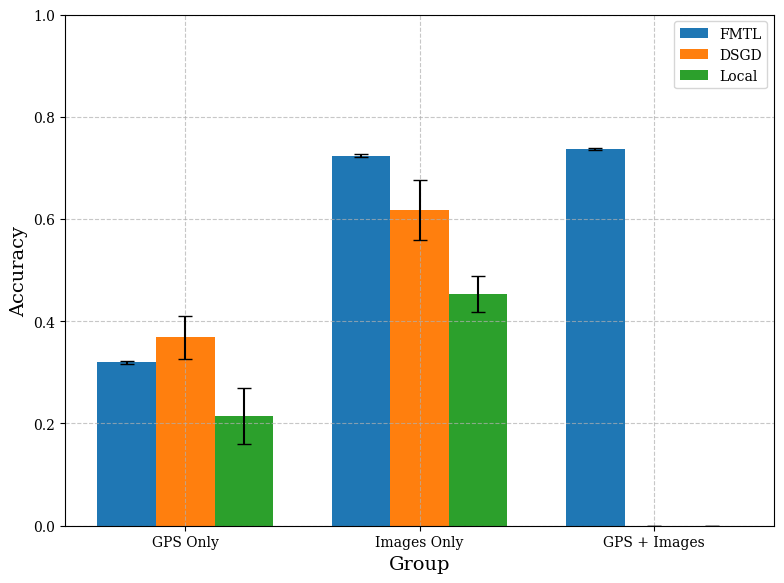

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and std for GPS-only, Images-only, and GPS+Images groups
groups = ['1', '2', '3']  # GPS-only, Images-only, GPS+Images
algorithms = ['Centralized', 'FMTL', 'DSGD', 'Local']

means = {algo: [] for algo in algorithms}
stds = {algo: [] for algo in algorithms}

for group in groups:
    for algo in algorithms:
        if algo == 'FMTL' and group in fmtl_group_val_accuracy_histories:
            mean_acc = np.mean(fmtl_group_val_accuracy_histories[group])
            std_acc = np.mean(fmtl_group_val_acc_std[group])
        elif algo == 'DSGD' and group in dsgd_group_val_accuracy_histories:
            mean_acc = np.mean(dsgd_group_val_accuracy_histories[group])
            std_acc = np.mean(dsgd_group_val_acc_std[group])
        elif algo == 'Local' and group in local_group_val_accuracy_histories:
            mean_acc = np.mean(local_group_val_accuracy_histories[group])
            std_acc = np.mean(local_group_val_acc_std[group])
        else:
            mean_acc = 0
            std_acc = 0
        means[algo].append(mean_acc)
        stds[algo].append(std_acc)

# Bar plot
x_labels = ['GPS Only', 'Images Only', 'GPS + Images']
x = np.arange(len(x_labels))
width = 0.25

plt.figure(figsize=(8, 6))
plt.bar(x - width, means['FMTL'], width, yerr=stds['FMTL'], label='FMTL', capsize=5, color=colors[0])
plt.bar(x, means['DSGD'], width, yerr=stds['DSGD'], label='DSGD', capsize=5, color=colors[1])
plt.bar(x + width, means['Local'], width, yerr=stds['Local'], label='Local', capsize=5, color=colors[2])

plt.xlabel('Group')
plt.ylabel('Accuracy')
#plt.title('Accuracy Comparison (GPS, Images, GPS + Images)')
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.grid(False, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('accuracy_comparison_barplot.pdf')
plt.show()


# Full image accuracy comparison

1
2
3


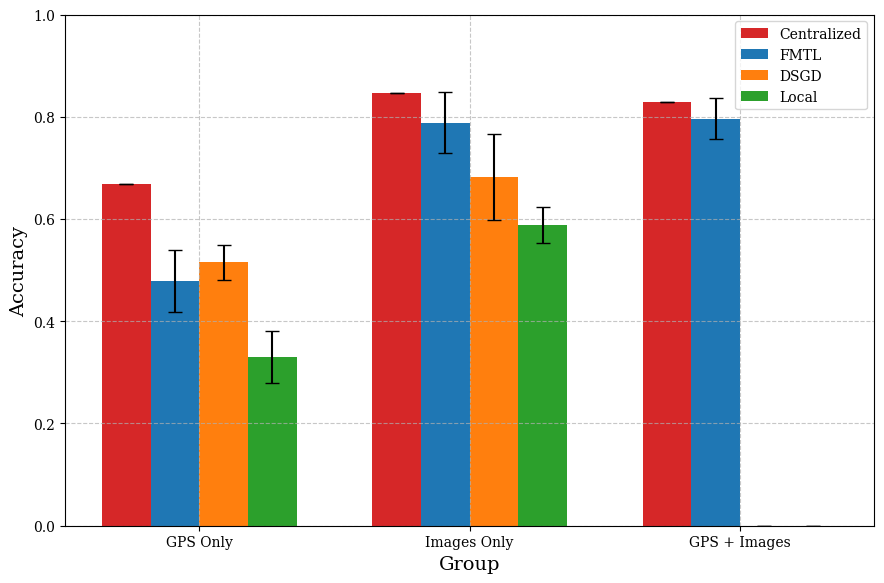

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import json



# Assuming the file structure is:
# {
#   "1": {"mean": 0.85, "std": 0.02},
#   "2": {"mean": 0.80, "std": 0.03},
#   "3": {"mean": 0.88, "std": 0.025}
# }

# Calculate mean and std for GPS-only, Images-only, and GPS+Images groups
groups = ['1', '2', '3']  # GPS-only, Images-only, GPS+Images
algorithms = ['Centralized', 'FMTL', 'DSGD', 'Local']

means = {algo: [] for algo in algorithms}
stds = {algo: [] for algo in algorithms}

for group in groups:
    for algo in algorithms:
        if algo == 'Centralized' and group in central_group_val_accuracy_histories:
            print(group)
            mean_acc = central_group_val_accuracy_histories[group][-1]
            std_acc = central_group_val_acc_std[group][-1]
        elif algo == 'FMTL' and group in fmtl_group_val_accuracy_histories:
            mean_acc = fmtl_group_val_accuracy_histories[group][-1]
            std_acc = fmtl_group_val_acc_std[group][-1]
        elif algo == 'DSGD' and group in dsgd_group_val_accuracy_histories:
            mean_acc = dsgd_group_val_accuracy_histories[group][-1]
            std_acc = dsgd_group_val_acc_std[group][-1]
        elif algo == 'Local' and group in local_group_val_accuracy_histories:
            mean_acc = local_group_val_accuracy_histories[group][-1]
            std_acc = local_group_val_acc_std[group][-1]
        else:
            mean_acc = 0
            std_acc = 0
        means[algo].append(mean_acc)
        stds[algo].append(std_acc)

# Bar plot
x_labels = ['GPS Only', 'Images Only', 'GPS + Images']
x = np.arange(len(x_labels))
width = 0.18

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(9, 6))
plt.bar(x - 1.5 * width, means['Centralized'], width, yerr=stds['Centralized'], label='Centralized', capsize=5, color=colors[3])
plt.bar(x - 0.5 * width, means['FMTL'], width, yerr=stds['FMTL'], label='FMTL', capsize=5, color=colors[0])
plt.bar(x + 0.5 * width, means['DSGD'], width, yerr=stds['DSGD'], label='DSGD', capsize=5, color=colors[1])
plt.bar(x + 1.5 * width, means['Local'], width, yerr=stds['Local'], label='Local', capsize=5, color=colors[2])

plt.xlabel('Group')
plt.ylabel('Accuracy')
#plt.title('Accuracy Comparison (GPS, Images, GPS + Images)')
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()

# Save or Show the plot
plt.savefig('accuracy_drone_barplot_full_image.pdf')
plt.show()


In [138]:
# Print and store results
latex_rows = []
print("Final Test Accuracy:")

for algo in algorithms:
    acc_values = []
    for group in groups:
        if algo == 'Centralized' and group in central_group_val_accuracy_histories:
            mean_acc = central_group_val_accuracy_histories[group][-1] * 100
        elif algo == 'FMTL' and group in fmtl_group_val_accuracy_histories:
            mean_acc = fmtl_group_val_accuracy_histories[group][-1]* 100
        elif algo == 'DSGD' and group in dsgd_group_val_accuracy_histories:
            mean_acc = dsgd_group_val_accuracy_histories[group][-1]* 100
        elif algo == 'Local' and group in local_group_val_accuracy_histories:
            mean_acc = local_group_val_accuracy_histories[group][-1]* 100
        else:
            mean_acc = 0.0
        
        acc_values.append(mean_acc)
    
    # Print results in the console
    print(f"{algo}: GPS Only={acc_values[0]:.2f}, Images Only={acc_values[1]:.2f}, GPS+Images={acc_values[2]:.2f}")
    
    # Add row for LaTeX table
    latex_rows.append(f"{algo} & {acc_values[0]:.2f} & {acc_values[1]:.2f} & {acc_values[2]:.2f} \\\\")

# Generate LaTeX Table
latex_code = r"""
\begin{table}[ht]
    \centering
    \begin{tabular}{lccc}
        \hline
        \textbf{Algorithm} & \textbf{GPS Only} & \textbf{Images Only} & \textbf{GPS + Images} \\
        \hline
""" + "\n".join(latex_rows) + r"""
        \hline
    \end{tabular}
    \caption{Final Test Accuracy for Different Algorithms and Groups}
    \label{tab:accuracy_results}
\end{table}
"""

# Save LaTeX code to a file
with open("accuracy_results.tex", "w") as file:
    file.write(latex_code)

# Print LaTeX table to console
print("\nLaTeX Table:")
print(latex_code)


Final Test Accuracy:
Centralized: GPS Only=66.81, Images Only=84.56, GPS+Images=82.84
FMTL: GPS Only=47.86, Images Only=78.83, GPS+Images=79.60
DSGD: GPS Only=51.56, Images Only=68.19, GPS+Images=0.00
Local: GPS Only=32.94, Images Only=58.83, GPS+Images=0.00

LaTeX Table:

\begin{table}[ht]
    \centering
    \begin{tabular}{lccc}
        \hline
        \textbf{Algorithm} & \textbf{GPS Only} & \textbf{Images Only} & \textbf{GPS + Images} \\
        \hline
Centralized & 66.81 & 84.56 & 82.84 \\
FMTL & 47.86 & 78.83 & 79.60 \\
DSGD & 51.56 & 68.19 & 0.00 \\
Local & 32.94 & 58.83 & 0.00 \\
        \hline
    \end{tabular}
    \caption{Final Test Accuracy for Different Algorithms and Groups}
    \label{tab:accuracy_results}
\end{table}



# Partial image convergence

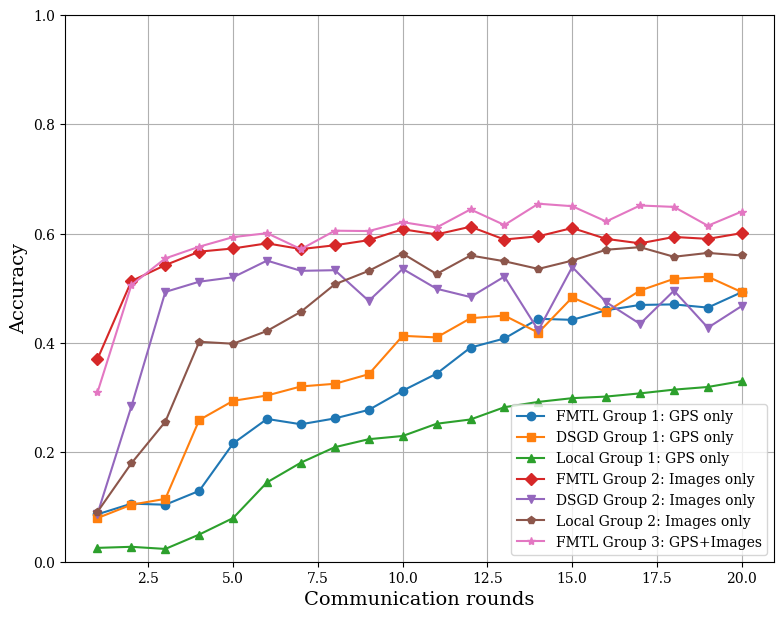

In [139]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Define metrics directory and file paths
metrics_directory = "./"
fmtl_metrics_file = f'{metrics_directory}FMTL_metrics_partial_image.json'
dsgd_metrics_file = f'{metrics_directory}DSGD_results_partial_image.json'
local_metrics_file = f'{metrics_directory}local_drone_partial_image.json'
centralized_metrics_file = f'{metrics_directory}centralized_drone_partial_image.json'

# Load the metrics from JSON files
def load_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

fmtl_metrics = load_json(fmtl_metrics_file)
dsgd_metrics = load_json(dsgd_metrics_file)
local_metrics = load_json(local_metrics_file)
centralized_metrics = load_json(centralized_metrics_file)

# Convert metrics to numpy arrays
fmtl_group_val_loss_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_mean'].items()}
fmtl_group_val_accuracy_histories = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_mean'].items()}
# Load DSGD and Local metrics
dsgd_group_val_loss_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_loss_mean'].items() if k != '3'}
dsgd_group_val_accuracy_histories = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_mean'].items() if k != '3'}
local_group_val_loss_histories = {k: np.array(v) for k, v in local_metrics['group_val_loss_mean'].items() if k != '3'}
local_group_val_accuracy_histories = {k: np.array(v) for k, v in local_metrics['group_val_acc_mean'].items() if k != '3'}
central_group_val_loss_histories = {k: np.array(v) for k, v in centralized_metrics['group_val_loss_mean'].items()}
central_group_val_accuracy_histories = {k: np.array(v) for k, v in centralized_metrics['group_val_acc_mean'].items()}


# Standard deviations
fmtl_group_val_loss_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_loss_std'].items()}
fmtl_group_val_acc_std = {k: np.array(v) for k, v in fmtl_metrics['group_val_acc_std'].items()}
dsgd_group_val_acc_std = {k: np.array(v) for k, v in dsgd_metrics['group_val_acc_std'].items()}
local_group_val_acc_std = {k: np.array(v) for k, v in local_metrics['group_val_acc_std'].items()}
central_group_val_acc_std = {k: np.array(v) for k, v in centralized_metrics['group_val_acc_std'].items()}
central_group_val_loss_std = {k: np.array(v) for k, v in centralized_metrics['group_val_loss_std'].items()}

# Rename groups
group_names = {'1': 'Group 1: GPS only', '2': 'Group 2: Images only', '3': 'Group 3: GPS+Images'}


markers = ['o', 's', '^', 'D', 'v', 'p', '*']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']  # Blue, Orange, Green, Red, Purple, Brown, Pink


# Plot results
plt.figure(figsize=(8, 12))
'''
# Validation Loss Plot
plt.subplot(2, 1, 1)
i = 0
for group in fmtl_group_val_loss_histories.keys():
    
    epochs = range(1, len(fmtl_group_val_loss_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_loss_histories[group], label=f"FMTL {group_names[group]}", marker=markers[i], color=colors[i])
    i = i + 1
    
    if group in dsgd_group_val_loss_histories:
        plt.plot(epochs, dsgd_group_val_loss_histories[group], label=f"DSGD {group_names[group]}", marker=markers[i], color=colors[i])  # Red
        i = i + 1
    if group in local_group_val_loss_histories:
        plt.plot(epochs, local_group_val_loss_histories[group], label=f"Local {group_names[group]}", marker=markers[i], color=colors[i])  # Purple
        i = i + 1
plt.title("Validation Loss vs Communication Rounds (FMTL, DSGD, Local)")
plt.xlabel("Communication rounds")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid()
'''
i = 0

# Validation Accuracy Plot
plt.subplot(2, 1, 2)
for group in fmtl_group_val_accuracy_histories.keys():
    epochs = range(1, len(fmtl_group_val_accuracy_histories[group]) + 1)
    plt.plot(epochs, fmtl_group_val_accuracy_histories[group], label=f"FMTL {group_names[group]}", marker=markers[i], color=colors[i])
    i = i + 1
    if group in dsgd_group_val_accuracy_histories:
        plt.plot(epochs, dsgd_group_val_accuracy_histories[group], label=f"DSGD {group_names[group]}", marker=markers[i], color=colors[i])  # Red
        i = i + 1
    if group in local_group_val_accuracy_histories:
        plt.plot(epochs, local_group_val_accuracy_histories[group], label=f"Local {group_names[group]}", marker=markers[i], color=colors[i])  # Purple
        i = i + 1
    
plt.xlabel("Communication rounds")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Accuracy should be between 0 and 1
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

plt.savefig('Acuracy_drone_curve_partial_images.pdf')

plt.show()

In [140]:
local_group_val_accuracy_histories

{'1': array([0.02534113, 0.02729045, 0.02339181, 0.0497076 , 0.07992203,
        0.14522417, 0.18128655, 0.20955166, 0.22417154, 0.23001949,
        0.25243665, 0.26023392, 0.28265107, 0.29239766, 0.29922027,
        0.30214425, 0.3079922 , 0.31481481, 0.31968811, 0.33040936]),
 '2': array([0.09122807, 0.18011696, 0.25614035, 0.40233918, 0.39883041,
        0.42222222, 0.45730994, 0.50760234, 0.53216374, 0.56374269,
        0.52631579, 0.56023392, 0.5497076 , 0.53567251, 0.55087719,
        0.57076023, 0.5754386 , 0.55789474, 0.56491228, 0.56023392])}

# Partial image accuracy comparison

1
2
3


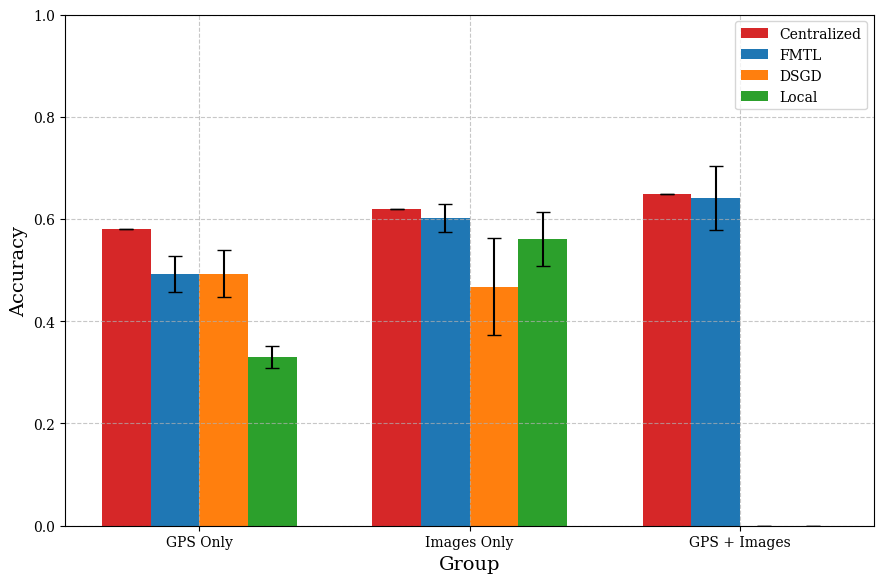

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import json



# Assuming the file structure is:
# {
#   "1": {"mean": 0.85, "std": 0.02},
#   "2": {"mean": 0.80, "std": 0.03},
#   "3": {"mean": 0.88, "std": 0.025}
# }

# Calculate mean and std for GPS-only, Images-only, and GPS+Images groups
groups = ['1', '2', '3']  # GPS-only, Images-only, GPS+Images
algorithms = ['Centralized', 'FMTL', 'DSGD', 'Local']

means = {algo: [] for algo in algorithms}
stds = {algo: [] for algo in algorithms}

for group in groups:
    for algo in algorithms:
        if algo == 'Centralized' and group in central_group_val_accuracy_histories:
            print(group)
            mean_acc = central_group_val_accuracy_histories[group][-1]
            std_acc = central_group_val_acc_std[group][-1]
        elif algo == 'FMTL' and group in fmtl_group_val_accuracy_histories:
            mean_acc = fmtl_group_val_accuracy_histories[group][-1]
            std_acc = fmtl_group_val_acc_std[group][-1]
        elif algo == 'DSGD' and group in dsgd_group_val_accuracy_histories:
            mean_acc = dsgd_group_val_accuracy_histories[group][-1]
            std_acc = dsgd_group_val_acc_std[group][-1]
        elif algo == 'Local' and group in local_group_val_accuracy_histories:
            mean_acc = local_group_val_accuracy_histories[group][-1]
            std_acc = local_group_val_acc_std[group][-1]
        else:
            mean_acc = 0
            std_acc = 0
        means[algo].append(mean_acc)
        stds[algo].append(std_acc)


# Bar plot
x_labels = ['GPS Only', 'Images Only', 'GPS + Images']
x = np.arange(len(x_labels))
width = 0.18

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

plt.figure(figsize=(9, 6))
plt.bar(x - 1.5 * width, means['Centralized'], width, yerr=stds['Centralized'], label='Centralized', capsize=5, color=colors[3])
plt.bar(x - 0.5 * width, means['FMTL'], width, yerr=stds['FMTL'], label='FMTL', capsize=5, color=colors[0])
plt.bar(x + 0.5 * width, means['DSGD'], width, yerr=stds['DSGD'], label='DSGD', capsize=5, color=colors[1])
plt.bar(x + 1.5 * width, means['Local'], width, yerr=stds['Local'], label='Local', capsize=5, color=colors[2])

plt.xlabel('Group')
plt.ylabel('Accuracy')
#plt.title('Accuracy Comparison (GPS, Images, GPS + Images)')
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()

# Save or Show the plot
#plt.savefig('Acuracy_drone_barplot_partial_images.pdf')
plt.show()


In [142]:
# Print and store results
latex_rows = []
print("Final Test Accuracy:")

for algo in algorithms:
    acc_values = []
    for group in groups:
        if algo == 'Centralized' and group in central_group_val_accuracy_histories:
            mean_acc = central_group_val_accuracy_histories[group][-1] * 100
        elif algo == 'FMTL' and group in fmtl_group_val_accuracy_histories:
            mean_acc = fmtl_group_val_accuracy_histories[group][-1]* 100
        elif algo == 'DSGD' and group in dsgd_group_val_accuracy_histories:
            mean_acc = dsgd_group_val_accuracy_histories[group][-1]* 100
        elif algo == 'Local' and group in local_group_val_accuracy_histories:
            mean_acc = local_group_val_accuracy_histories[group][-1]* 100
        else:
            mean_acc = 0.0
        
        acc_values.append(mean_acc)
    
    # Print results in the console
    print(f"{algo}: GPS Only={acc_values[0]:.2f}, Images Only={acc_values[1]:.2f}, GPS+Images={acc_values[2]:.2f}")
    
    # Add row for LaTeX table
    latex_rows.append(f"{algo} & {acc_values[0]:.2f} & {acc_values[1]:.2f} & {acc_values[2]:.2f} \\\\")

# Generate LaTeX Table
latex_code = r"""
\begin{table}[ht]
    \centering
    \begin{tabular}{lccc}
        \hline
        \textbf{Algorithm} & \textbf{GPS Only} & \textbf{Images Only} & \textbf{GPS + Images} \\
        \hline
""" + "\n".join(latex_rows) + r"""
        \hline
    \end{tabular}
    \caption{Final Test Accuracy for Different Algorithms and Groups}
    \label{tab:accuracy_results}
\end{table}
"""

# Save LaTeX code to a file
with open("accuracy_results.tex", "w") as file:
    file.write(latex_code)

# Print LaTeX table to console
print("\nLaTeX Table:")
print(latex_code)


Final Test Accuracy:
Centralized: GPS Only=58.00, Images Only=61.90, GPS+Images=64.97
FMTL: GPS Only=49.32, Images Only=60.12, GPS+Images=64.07
DSGD: GPS Only=49.32, Images Only=46.78, GPS+Images=0.00
Local: GPS Only=33.04, Images Only=56.02, GPS+Images=0.00

LaTeX Table:

\begin{table}[ht]
    \centering
    \begin{tabular}{lccc}
        \hline
        \textbf{Algorithm} & \textbf{GPS Only} & \textbf{Images Only} & \textbf{GPS + Images} \\
        \hline
Centralized & 58.00 & 61.90 & 64.97 \\
FMTL & 49.32 & 60.12 & 64.07 \\
DSGD & 49.32 & 46.78 & 0.00 \\
Local & 33.04 & 56.02 & 0.00 \\
        \hline
    \end{tabular}
    \caption{Final Test Accuracy for Different Algorithms and Groups}
    \label{tab:accuracy_results}
\end{table}



In [145]:
fmtl_group_val_accuracy_histories['1'][-1]* 100

49.317738791423004